In [1]:
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
#import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load

import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

sklearn: 0.23.2
tensorflow: 2.3.1


In [2]:
#tf.config.experimental.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    
print ( gpus )

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#proton_selection = "SingleRP"
proton_selection = "MultiRP"

learning_rate_scan = False
train_model = False
run_grid_search = True
save_model = True

### Signal

In [4]:
#df_signal = None
#event_counts_signal = None
#selections_str_signal = None

df_signal_list = []
df_counts_signal_list = []

fileNames_signal = [
    'output/output-MC2017-Elastic-Non3+3-PreSel.h5'
    #'output-MC2017-SingleDissociation-PreSel.h5'
]

for file_ in fileNames_signal:
    print ( file_ )
    with h5py.File( file_, 'r' ) as f:
        print ( list(f.keys()) )
        dset = f['protons']
        print ( dset.shape )
        print ( dset[:,:] )
        dset_columns = f['columns']
        print ( dset_columns.shape )
        columns = list( dset_columns )
        print ( columns )
        columns_str = [ item.decode("utf-8") for item in columns ]
        print ( columns_str )

        dset_selections = f['selections']
        selections_ = [ item.decode("utf-8") for item in dset_selections ]
        print ( selections_ )

        dset_counts = f['event_counts']
        df_counts_signal_list.append( pd.Series( dset_counts, index=selections_ ) )
        print ( df_counts_signal_list[-1] )

        df_ = pd.DataFrame( dset, columns=columns_str )
        df_ = df_[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
                    'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
                    'Xi', 'T', 'ThX', 'ThY', 'Time',
                    'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )
        df_signal_list.append( df_ )
        print ( df_signal_list[-1].head() )
        print ( len( df_signal_list[-1] ) )

output/output-MC2017-Elastic-Non3+3-PreSel.h5
['columns', 'event_counts', 'protons', 'selections']
(213536, 38)
[[1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 9.1376482e-04
  2.3529863e-02 4.4119707e-03]
 [1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 8.7998388e-04
  4.5879604e-03 8.1510313e-02]
 [1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 8.7998388e-04
  4.5879604e-03 8.1510313e-02]
 ...
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 2.6697566e-04
  2.1097749e-03 4.5376737e-02]
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 1.8521260e-04
  3.6291495e-02 3.0596652e-03]
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 1.8521260e-04
  3.6291495e-02 3.0596652e-03]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP

In [5]:
df_counts_signal = df_counts_signal_list[0]
for idx in range( 1, len( df_counts_signal_list ) ):
    df_counts_signal = df_counts_signal.add( df_counts_signal_list[idx] )
df_counts_signal

All        178402
Muon       166756
Vertex     149608
Protons     91429
dtype: int64

In [6]:
df_signal = pd.concat( df_signal_list )

In [7]:
msk_sig = ( df_signal["InvMass"] >= 110. )

msk1_sig = None
msk2_sig = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk1_arm = ( df_signal["RPId1"] == 23 )
    msk2_arm = ( df_signal["RPId1"] == 123 )
    df_signal[ "XiMuMu" ] = np.nan
    df_signal[ "XiMuMu" ].where( ~msk1_arm, df_signal[ "XiMuMuPlus" ], inplace=True )
    df_signal[ "XiMuMu" ].where( ~msk2_arm, df_signal[ "XiMuMuMinus" ], inplace=True )
    #df_signal[ "XiMuMu" ][ msk2_arm ] = df_signal[ "XiMuMuMinus" ] 
    msk1_sig = msk_sig & ( df_signal["MultiRP"] == 0) & msk1_arm
    msk2_sig = msk_sig & ( df_signal["MultiRP"] == 0) & msk2_arm
elif proton_selection == "MultiRP":
    # Multi-RP
    msk1_arm = ( df_signal["Arm"] == 0 )
    msk2_arm = ( df_signal["Arm"] == 1 )
    df_signal[ "XiMuMu" ] = np.nan
    df_signal[ "XiMuMu" ].where( ~msk1_arm, df_signal[ "XiMuMuPlus" ], inplace=True )
    df_signal[ "XiMuMu" ].where( ~msk2_arm, df_signal[ "XiMuMuMinus" ], inplace=True )
    msk1_sig = msk_sig & ( df_signal["MultiRP"] == 1 ) & msk1_arm
    msk2_sig = msk_sig & ( df_signal["MultiRP"] == 1 ) & msk2_arm

df_signal = df_signal[ msk1_sig | msk2_sig ]
df_signal[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,ThY,Time,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu
3,1,1,3,150.0,1,1,103,123,7.630859,1.224731,...,0.000023,0.0,115.289131,114.552933,251.395355,16,0.000880,0.004588,0.081510,0.081510
6,1,1,12,150.0,1,0,3,23,5.149414,0.725220,...,0.000011,0.0,55.317619,52.814793,126.690613,4,0.001160,0.055618,0.001708,0.055618
16,1,1,17,150.0,1,1,103,123,3.828247,0.749878,...,0.000012,0.0,61.452324,60.853138,263.130524,1,0.000028,0.008177,0.050104,0.050104
19,1,1,30,150.0,1,0,3,23,5.139893,0.158340,...,0.000055,0.0,52.522842,51.576660,176.417725,1,0.001032,0.046055,0.003999,0.046055
24,1,1,13,150.0,1,1,103,123,2.742798,0.001996,...,0.000114,0.0,117.683517,115.790192,233.975662,17,0.000317,0.007711,0.042010,0.042010
27,1,1,31,150.0,1,1,103,123,5.258789,-0.745728,...,0.000083,0.0,84.892128,72.441437,266.681091,0,0.001807,0.006805,0.061971,0.061971
30,1,1,37,150.0,1,0,3,23,4.975342,1.117432,...,-0.000015,0.0,69.889496,66.498047,176.964508,0,0.000757,0.054292,0.003414,0.054292
42,1,1,52,150.0,1,0,3,23,7.566895,0.678040,...,0.000004,0.0,299.492554,274.796112,1466.510620,2,0.000317,0.072588,0.175365,0.072588
43,1,1,52,150.0,1,1,103,123,11.388184,3.717285,...,-0.000008,0.0,299.492554,274.796112,1466.510620,2,0.000317,0.072588,0.175365,0.175365
46,1,1,57,150.0,1,1,103,123,3.813232,1.491821,...,-0.000037,0.0,58.605152,56.575214,115.234695,0,0.000651,0.001538,0.051120,0.051120


### Background

In [8]:
df_bkg_list = []
df_counts_bkg_list = []

resample_factor = 20

fileNames_bkg = [
    'output/output-UL2017B-PreSel-Rnd-Res20.h5',
    'output/output-UL2017C1-PreSel-Rnd-Res20.h5',
    'output/output-UL2017E-PreSel-Rnd-Res20.h5',
    'output/output-UL2017F1-PreSel-Rnd-Res20.h5'
]

for file_ in fileNames_bkg:
    print ( file_ )
    with h5py.File( file_, 'r' ) as f:
        print ( list(f.keys()) )
        dset = f['protons']
        print ( dset.shape )
        print ( dset[:,:] )
        
        dset_columns = f['columns']
        print ( dset_columns.shape )
        columns = list( dset_columns )
        print ( columns )
        columns_str = [ item.decode("utf-8") for item in columns ]
        print ( columns_str )

        dset_selections = f['selections']
        selections_ = [ item.decode("utf-8") for item in dset_selections ]
        print ( selections_ )
        
        dset_counts = f['event_counts']
        df_counts_bkg_list.append( pd.Series( dset_counts, index=selections_ ) )
        print ( df_counts_bkg_list[-1] )
       
        chunk_size = 1000000
        entries = dset.shape[0]
        start_ = list( range( 0, entries, chunk_size ) )
        stop_ = start_[1:]
        stop_.append( entries )
        print ( start_ )
        print ( stop_ )
        for idx in range( len( start_ ) ):
            print ( start_[idx], stop_[idx] )
            #print ( dset[ start_[idx] : stop_[idx] ] )
            df_ = pd.DataFrame( dset[ start_[idx] : stop_[idx] ], columns=columns_str )
            df_ = df_[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
                        'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
                        'Xi', 'T', 'ThX', 'ThY', 'Time',
                        'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )
            df_bkg_list.append( df_ )
            print ( df_bkg_list[-1].head() )
            print ( len( df_bkg_list[-1] ) )

output/output-UL2017B-PreSel-Rnd-Res20.h5
['columns', 'event_counts', 'protons', 'selections']
(2141500, 38)
[[2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 [2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 [2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 ...
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP', 

      Run  LumiSection   EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  300560           97  116191336          120.0        1    1    103    123   
1  300560           97  116776680          120.0        0 -999    103     -1   
2  300560           97  116776680          120.0        0 -999    123     -1   
3  300560           97  116776680          120.0        1    1    103    123   
4  300560           97  115898864          120.0        0 -999      3     -1   

     TrackX1   TrackY1  ...       ThX       ThY      Time     Muon0Pt  \
0   3.778931  0.876831  ... -0.000016  0.000021  0.000000  136.861618   
1  12.148926  1.382080  ...  0.000000 -0.000023  0.000000  191.480087   
2  12.212402  1.428955  ...  0.000000 -0.000022  0.000000  191.480087   
3  12.148926  1.382080  ...  0.000047  0.000077  0.042752  191.480087   
4   9.083984  2.758789  ...  0.000000 -0.000102  0.000000   85.710884   

     Muon1Pt     InvMass  ExtraPfCands     Acopl  XiMuMuPlus  XiMuMuMinus  
0  8

      Run  LumiSection    EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  304292         1201  1823432832          120.0        0 -999    103     -1   
1  304292         1201  1823432832          120.0        0 -999    123     -1   
2  304292         1201  1823432832          120.0        1    1    103    123   
3  304292         1201  1822685568          120.0        0 -999    103     -1   
4  304292         1202  1824409472          120.0        0 -999     23     -1   

     TrackX1   TrackY1  ...       ThX       ThY      Time    Muon0Pt  \
0   9.696777 -1.657959  ...  0.000000  0.000032  0.000000  72.365654   
1   9.554810 -1.816406  ...  0.000000  0.000033  0.000000  72.365654   
2   9.696777 -1.657959  ... -0.000011  0.000143  0.056396  72.365654   
3  10.411133  5.502930  ...  0.000000 -0.000110  0.000000  88.793587   
4   3.107452  0.325287  ...  0.000000 -0.000074  0.000000  62.810257   

     Muon1Pt     InvMass  ExtraPfCands     Acopl  XiMuMuPlus  XiMuMuMinus  
0  5

      Run  LumiSection   EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  304366          253  428432256          150.0        0 -999    123     -1   
1  304366          253  428432256          150.0        1    1    103    123   
2  304366          253  428421760          150.0        0 -999     23     -1   
3  304366          253  428421760          150.0        0 -999     23     -1   
4  304366          253  428421760          150.0        0 -999     23     -1   

     TrackX1   TrackY1  ...       ThX       ThY      Time    Muon0Pt  \
0  14.591431  1.759155  ...  0.000000 -0.000019  0.000000  80.959167   
1  14.569824  1.715576  ...  0.000048  0.000120 -0.330009  80.959167   
2   2.407715  0.573608  ...  0.000000 -0.000255  0.000000  66.265289   
3   3.254150 -0.495361  ...  0.000000  0.000076  0.000000  66.265289   
4   3.579498  0.200668  ...  0.000000 -0.000025  0.000000  66.265289   

     Muon1Pt     InvMass  ExtraPfCands     Acopl  XiMuMuPlus  XiMuMuMinus  
0  76.1407

      Run  LumiSection   EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  305081          172  235603664          150.0        0 -999    123     -1   
1  305081          172  235603664          150.0        1    0      3     23   
2  305081          172  235603664          150.0        1    1    103    123   
3  305081          172  235748784          150.0        0 -999      3     -1   
4  305081          172  235748784          150.0        0 -999     23     -1   

     TrackX1   TrackY1  ...       ThX       ThY  Time    Muon0Pt    Muon1Pt  \
0  10.326782 -2.386475  ...  0.000000  0.000034   0.0  91.016975  72.235619   
1   4.918945 -0.112457  ...  0.000191  0.000087   0.0  91.016975  72.235619   
2  10.731934 -2.184814  ... -0.000052  0.000245   0.0  91.016975  72.235619   
3  13.570312  5.555664  ...  0.000000 -0.000112   0.0  93.529984  75.133713   
4   2.975891  0.609863  ...  0.000000 -0.000161   0.0  93.529984  75.133713   

     InvMass  ExtraPfCands     Acopl  XiMuMu

In [9]:
df_counts_bkg = df_counts_bkg_list[0]
for idx in range( 1, len( df_counts_bkg_list ) ):
    df_counts_bkg = df_counts_bkg.add( df_counts_bkg_list[idx] )
df_counts_bkg

All           869119560
Muon            8456020
Vertex          7782360
ProtonsRnd      6301680
dtype: int64

In [10]:
df_bkg = pd.concat( df_bkg_list )

In [11]:
msk_bkg = ( df_bkg["InvMass"] >= 110. )

msk1_bkg = None
msk2_bkg = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk1_arm = ( df_bkg["RPId1"] == 23 )
    msk2_arm = ( df_bkg["RPId1"] == 123 )
    df_bkg[ "XiMuMu" ] = np.nan
    df_bkg[ "XiMuMu" ].where( ~msk1_arm, df_bkg[ "XiMuMuPlus" ], inplace=True )
    df_bkg[ "XiMuMu" ].where( ~msk2_arm, df_bkg[ "XiMuMuMinus" ], inplace=True )
    msk1_bkg = msk_bkg & ( df_bkg["MultiRP"] == 0) & msk1_arm
    msk2_bkg = msk_bkg & ( df_bkg["MultiRP"] == 0) & msk2_arm
elif proton_selection == "MultiRP":
    # Multi-RP
    msk1_arm = ( df_bkg["Arm"] == 0 )
    msk2_arm = ( df_bkg["Arm"] == 1 )
    df_bkg[ "XiMuMu" ] = np.nan
    df_bkg[ "XiMuMu" ].where( ~msk1_arm, df_bkg[ "XiMuMuPlus" ], inplace=True )
    df_bkg[ "XiMuMu" ].where( ~msk2_arm, df_bkg[ "XiMuMuMinus" ], inplace=True )
    msk1_bkg = msk_bkg & ( df_bkg["MultiRP"] == 1 ) & msk1_arm
    msk2_bkg = msk_bkg & ( df_bkg["MultiRP"] == 1 ) & msk2_arm

df_bkg = df_bkg[ msk1_bkg | msk2_bkg ]
df_bkg[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,ThY,Time,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu
10,297227,56,38791640,120.0,1,0,3,23,7.063232,1.953613,...,-4.635066e-05,0.0,65.270454,65.022888,152.786011,29,0.058782,0.002211,0.062855,0.002211
20,297227,58,40362008,120.0,1,0,3,23,7.391113,2.280518,...,-1.740635e-05,0.0,80.369690,68.791176,228.323425,10,0.271141,0.028539,0.011619,0.028539
33,297227,60,41478176,120.0,1,0,3,23,6.782959,1.464966,...,-5.399367e-05,0.0,114.150841,93.884605,323.668549,40,0.157789,0.035037,0.018197,0.035037
47,297227,63,44189296,120.0,1,0,3,23,13.382812,-1.072510,...,6.678360e-05,0.0,138.408752,108.538467,245.222839,53,0.008506,0.033806,0.010684,0.033806
69,297227,73,52238048,120.0,1,1,103,123,8.629883,1.481323,...,7.347923e-05,0.0,86.516212,56.114479,138.904510,10,0.060892,0.014483,0.008333,0.008333
84,297227,75,53449356,120.0,1,1,103,123,5.546875,1.592651,...,6.509769e-07,0.0,74.069061,62.750038,159.699677,53,0.023202,0.019344,0.007848,0.007848
93,297227,76,54126336,120.0,1,0,3,23,8.200684,3.784912,...,-7.809676e-05,0.0,75.266441,69.694183,223.032425,59,0.145185,0.049092,0.006129,0.049092
111,297227,78,55898044,120.0,1,1,103,123,3.611084,1.855103,...,-1.616523e-05,0.0,58.097786,53.140121,126.642601,84,0.273834,0.032531,0.003312,0.003312
118,297227,79,56863080,120.0,1,1,103,123,3.396606,1.380615,...,-2.309114e-05,0.0,61.966732,50.172760,127.597572,21,0.026694,0.001631,0.059633,0.059633
138,297227,86,61943160,120.0,1,0,3,23,7.637451,1.072144,...,-4.634655e-05,0.0,91.612099,71.395660,163.843567,62,0.095938,0.016999,0.009692,0.016999


### Select variables

In [12]:
X_sig = df_signal[ ['Xi', 'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMu'] ]
X_sig[:20]

,Xi,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMu
3,0.079777,115.289131,114.552933,251.395355,16,0.000880,0.081510
6,0.058544,55.317619,52.814793,126.690613,4,0.001160,0.055618
16,0.052047,61.452324,60.853138,263.130524,1,0.000028,0.050104
19,0.045926,52.522842,51.576660,176.417725,1,0.001032,0.046055
24,0.041798,117.683517,115.790192,233.975662,17,0.000317,0.042010
27,0.073885,84.892128,72.441437,266.681091,0,0.001807,0.061971
30,0.055212,69.889496,66.498047,176.964508,0,0.000757,0.054292
42,0.076750,299.492554,274.796112,1466.510620,2,0.000317,0.072588
43,0.173075,299.492554,274.796112,1466.510620,2,0.000317,0.175365
46,0.050896,58.605152,56.575214,115.234695,0,0.000651,0.051120


In [13]:
X_bkg = df_bkg[ ['Xi', 'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMu'] ]
X_bkg[:20]

,Xi,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMu
10,0.087538,65.270454,65.022888,152.786011,29,0.058782,0.002211
20,0.094858,80.369690,68.791176,228.323425,10,0.271141,0.028539
33,0.053182,114.150841,93.884605,323.668549,40,0.157789,0.035037
47,0.101070,138.408752,108.538467,245.222839,53,0.008506,0.033806
69,0.110202,86.516212,56.114479,138.904510,10,0.060892,0.008333
84,0.076194,74.069061,62.750038,159.699677,53,0.023202,0.007848
93,0.079165,75.266441,69.694183,223.032425,59,0.145185,0.049092
111,0.063853,58.097786,53.140121,126.642601,84,0.273834,0.003312
118,0.055931,61.966732,50.172760,127.597572,21,0.026694,0.059633
138,0.074558,91.612099,71.395660,163.843567,62,0.095938,0.016999


In [14]:
y_sig = np.ones( len(X_sig) )
y_bkg = np.zeros( len(X_bkg) )

X = pd.concat( [X_sig, X_bkg] ) 
y = np.concatenate( [y_sig, y_bkg] )

In [15]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split( X, y, test_size=0.20, shuffle=True, random_state=42 )
X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full, test_size=0.20, shuffle=False )

### Scale inputs

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform( X_train )
X_valid_scaled = scaler.transform( X_valid )
X_test_scaled = scaler.transform( X_test )

In [17]:
print ( scaler )
if train_model and save_model:
    dump( scaler, "model/standard_scaler.joblib")

StandardScaler()


In [18]:
X_train_scaled[:20]

array([[-0.81856211,  0.0285441 , -0.09295316, -0.74005583,  0.078331  ,
         2.91811836, -0.76232871],
       [ 1.29751505, -0.26251739, -0.64778136, -0.74422724, -0.32899844,
         1.49656285,  0.39505141],
       [ 0.71827449, -0.44086804, -0.37531829, -0.40936567,  1.70764878,
        -0.65076783, -0.74985716],
       [-0.74452599, -0.24292642,  0.13485089,  0.30778959, -1.68676326,
        -0.69345657,  1.25791478],
       [ 0.34589777, -0.39135018, -0.17834209, -0.42041919, -0.82684554,
        -0.69121509, -0.37887098],
       [ 2.29267326, -0.60902737, -0.44116789, -0.14973621, -0.4195161 ,
         0.19232247, -0.75700318],
       [ 2.59967655, -0.26516064, -0.33576577, -0.40035203,  0.34988396,
        -0.51226976,  2.03352237],
       [-0.17898951, -0.581647  , -0.52017935, -0.6416584 ,  1.84342526,
         0.18595292, -0.29443123],
       [-0.67409078, -0.70514114, -0.51335055, -0.7079329 ,  1.79816643,
        -0.64301617, -0.20505605],
       [-0.67830352, -0.6726

### Model build function

In [19]:
def build_model(n_hidden=1, n_neurons=50, learning_rate=5e-4, input_shape=X_train_scaled.shape[1:], dropout=0.20):
    print( "Building model with:" )
    print( "Number of hidden layers: {}".format(n_hidden) )
    print( "Number of neurons per layer: {}".format(n_neurons) )
    print( "Learning rate: {}".format(learning_rate) )
    print( "Input shape: {}".format(input_shape) )
    print( "Dropout rate: {}".format(dropout) )
    
    model = keras.models.Sequential()
    model.add( keras.layers.InputLayer(input_shape=input_shape) )
    for layer in range(n_hidden):
        if dropout > 0.:
            model.add( keras.layers.Dropout(rate=dropout) )
        model.add( keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal") )
    if dropout > 0.:
        model.add( keras.layers.Dropout(rate=dropout) )    
    model.add( keras.layers.Dense(1, activation="sigmoid") )
    
    #optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
    optimizer = keras.optimizers.Nadam(lr=learning_rate)
    model.compile( loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

### Define training callbacks

In [20]:
def get_run_logdir(log_dir):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(log_dir, run_id)

In [21]:
def callbacks(patience=10, log_dir=""):
    callbacks_ = []
    # Early stopping
    if patience > 0:
        early_stopping_cb_ = keras.callbacks.EarlyStopping( patience=patience, restore_best_weights=True )
        callbacks_.append( early_stopping_cb_ )
        
    # TensorBoard
    if log_dir:
        run_logdir = get_run_logdir(log_dir)
        print ( "Log dir: {}".format(run_logdir) )
        tensorboard_cb_ = keras.callbacks.TensorBoard( run_logdir )
        callbacks_.append( tensorboard_cb_ )
    
    return callbacks_

In [22]:
log_dir="keras_logs"
callbacks_ = callbacks(patience=5, log_dir=log_dir)
callbacks_

Log dir: keras_logs/run_2020_11_17-20_17_12


### Build model (example)

In [23]:
model = build_model( 
    n_hidden=1,
    n_neurons=50,
    learning_rate=1e-4,
    input_shape=X_train_scaled.shape[1:],
    dropout=0.50
    )
model.summary()

Building model with:
Number of hidden layers: 1
Number of neurons per layer: 50
Learning rate: 0.0001
Input shape: (7,)
Dropout rate: 0.5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 50)                400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit( X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
history.history

Epoch 1/100
    1/27550 [..............................] - ETA: 0s - loss: 1.4236 - accuracy: 0.6250WARNING:tensorflow:From /home/antoniovilela/workspace/envs/tf-gpu-py37/lib64/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
27550/27550 [==============================] - 54s 2ms/step - loss: 0.1764 - accuracy: 0.9462 - val_loss: 0.0660 - val_accuracy: 0.9647
Epoch 2/100
27550/27550 [==============================] - 54s 2ms/step - loss: 0.1055 - accuracy: 0.9680 - val_loss: 0.0658 - val_accuracy: 0.9647
Epoch 3/100
27550/27550 [==============================] - 54s 2ms/step - loss: 0.0996 - accuracy: 0.9697 - val_loss: 0.0660 - val_accuracy: 0.9647
Epoch 4/100
27550/27550 [==============================] - 55s 2ms/step - loss: 0.0969 - accuracy: 0.9708 - val_loss: 0.0666 - val_accuracy: 0.9647
Epoc

{'loss': [0.17644542455673218,
  0.10551591217517853,
  0.09957016259431839,
  0.09688201546669006,
  0.09549453109502792,
  0.09478522837162018,
  0.09402823448181152],
 'accuracy': [0.9461631774902344,
  0.9679533839225769,
  0.9697433114051819,
  0.970797061920166,
  0.9715162515640259,
  0.9717816710472107,
  0.9720901846885681],
 'val_loss': [0.06603600829839706,
  0.06580215692520142,
  0.06596417725086212,
  0.06660813093185425,
  0.06685049086809158,
  0.0672951489686966,
  0.06849709898233414],
 'val_accuracy': [0.9646593928337097,
  0.9647229313850403,
  0.9647002220153809,
  0.9646684527397156,
  0.9646729826927185,
  0.9646684527397156,
  0.9646639227867126]}

<AxesSubplot:>

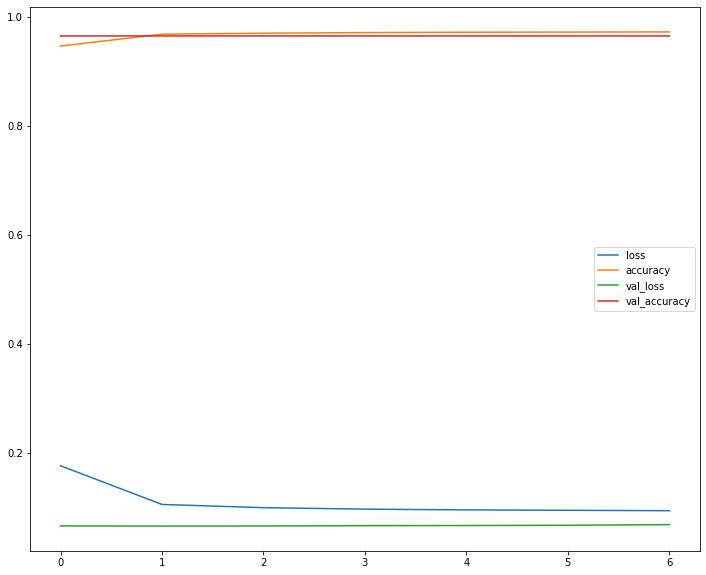

In [25]:
pd.DataFrame( history.history ).plot( figsize=(12,10) )

### Evaluate on training data (without dropout)

In [26]:
model.evaluate( X_train_scaled, y_train )

27550/27550 [==============================] - 27s 975us/step - loss: 0.0664 - accuracy: 0.9646


[0.06635448336601257, 0.9645810127258301]

### Evaluate on test data

In [27]:
model.evaluate( X_test_scaled, y_test )

8610/8610 [==============================] - 8s 897us/step - loss: 0.0656 - accuracy: 0.9652


[0.06562615185976028, 0.9651830792427063]

In [28]:
y_test_proba = model.predict( X_test_scaled )
print ( y_test_proba.shape )
y_test_proba

(275498, 1)


array([[0.00461   ],
       [0.00821897],
       [0.00036575],
       ...,
       [0.0236454 ],
       [0.01063277],
       [0.0011239 ]], dtype=float32)

### Scan over different learning rates

In [29]:
def find_max_learning_rate( lr_init=1e-4, lr_end=5e-2, steps=20, epochs=30, model_build_fn=build_model, *build_fn_args, **build_fn_kwargs ):
    results_ = {}
    results_['learning_rate'] = []
    results_['loss'] = []
    results_['accuracy'] = []
    results_['val_loss'] = []
    results_['val_accuracy'] = []
    c_ = (lr_end/lr_init) ** (1/steps)
    lr_ = lr_init
    for i_it in range( steps + 1 ):
        results_['learning_rate'].append( lr_ )
        model_ = model_build_fn( *build_fn_args, **build_fn_kwargs, learning_rate=lr_ )
        callbacks_ = callbacks(patience=5)
        history_ = model_.fit( X_train_scaled, y_train, epochs=epochs, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
        results_['loss'].append( history_.history['loss'] )
        results_['accuracy'].append( history_.history['accuracy'] )
        results_['val_loss'].append( history_.history['val_loss'] )
        results_['val_accuracy'].append( history_.history['val_accuracy'] )
        # Update learning rate
        lr_ = lr_ * c_
        
    return results_


In [30]:
epochs_lr_scan=20
results = None
if learning_rate_scan:
    results = find_max_learning_rate(
                lr_init=1e-4,
                lr_end=2e-2,
                steps=10,
                epochs=epochs_lr_scan,
                model_build_fn=build_model,
                n_hidden=1,
                n_neurons=20,
                input_shape=X_train_scaled.shape[1:],
                dropout=0.50
                )

In [31]:
if learning_rate_scan:
    metrics_ = 'val_loss'
    columns=["lr_{}".format(lr_) for lr_ in np.round( results['learning_rate'], 4)] 
    df = pd.DataFrame( np.full((epochs_lr_scan,len(columns)),np.nan), columns=columns )
    for i_lr_,col_ in enumerate(columns):
        df[col_] = pd.Series( results[ metrics_ ][i_lr_] )
    df.plot( figsize=(12,10) )
    plt.yscale('log')
    plt.show()

### Hyperparameter scan

In [32]:
learning_rate = 1e-4
dropout = 0.50
grid_search = None

if train_model and run_grid_search:
    #from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import GridSearchCV

    def build_fn_(n_hidden, n_neurons):
        return build_model(n_hidden, n_neurons, learning_rate=learning_rate, input_shape=X_train_scaled.shape[1:], dropout=dropout)

    keras_clf = keras.wrappers.scikit_learn.KerasClassifier( build_fn_ )

    #param_grid = [
    #    { "n_hidden": [2],
    #      "n_neurons": [50,100] }
    #    ]
    param_grid = [
        { "n_hidden": np.arange(1,3),
          "n_neurons": [20,50] }
        ]

    grid_search = GridSearchCV( keras_clf, param_grid, cv=3, scoring='f1', refit=False )

    callbacks_ = callbacks(patience=5)
    print ( callbacks_ )
    grid_search.fit( X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
    
    print ( grid_search.best_params_ )
    print ( grid_search.best_score_ )
    print ( grid_search.cv_results_ )

In [33]:
model_final = None

if train_model:
    params = {'n_hidden': 1, 'n_neurons': 50}
    if run_grid_search: 
        #print ( grid_search.best_params_ )
        #print ( grid_search.best_score_ )
        #print ( grid_search.best_estimator_)
        #model_gs = grid_search.best_estimator_.model
        #model_final = model_gs
        params = grid_search.best_params_
    print ( params )
    
    model_final = build_model(**params, learning_rate=8e-4, input_shape=X_train_scaled.shape[1:], dropout=0.40)
    model_final.summary()
    log_dir="keras_logs"
    callbacks_ = callbacks(patience=5, log_dir=log_dir)
    print ( callbacks_ )
    model_final.fit( X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
else:
    model_final = keras.models.load_model( "model/keras_model.h5" )
    
model_final.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_101 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_101 (Dense)            (None, 50)                400       
_________________________________________________________________
dropout_102 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 51        
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


### Evaluate on training data (without dropout)

In [34]:
model_final.evaluate( X_train_scaled, y_train )

27550/27550 [==============================] - 25s 901us/step - loss: 0.0547 - accuracy: 0.9650


[0.054664481431245804, 0.9650177359580994]

### Re-evaluate on validation data 

In [35]:
model_final.evaluate( X_valid_scaled, y_valid )

6888/6888 [==============================] - 7s 947us/step - loss: 0.0542 - accuracy: 0.9652


[0.05421905592083931, 0.9652038812637329]

### Evaluate on test data

In [36]:
model_final.evaluate( X_test_scaled, y_test )

y_test_proba = model_final.predict( X_test_scaled )
y_test_proba

8610/8610 [==============================] - 8s 912us/step - loss: 0.0541 - accuracy: 0.9656


array([[5.5896590e-04],
       [1.8495375e-03],
       [1.3954027e-05],
       ...,
       [1.1412134e-02],
       [3.5700884e-03],
       [1.5500173e-04]], dtype=float32)

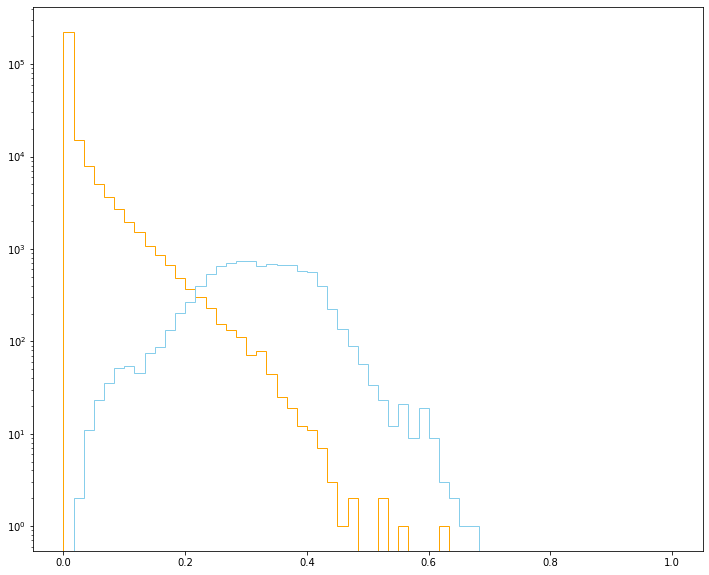

In [37]:
fig = plt.figure( figsize=(12,10) )
plt.hist( y_test_proba[ y_test == 0 ], histtype='step', color='orange', bins=60, range=(0.,1.) )
plt.hist( y_test_proba[ y_test == 1 ], histtype='step', color='skyblue', bins=60, range=(0.,1.) )
plt.yscale('log')

In [38]:
prob_cut = 0.15

y_test_pred = ( y_test_proba >= prob_cut ).astype( "int32" )
print ( y_test_pred )

from sklearn.metrics import accuracy_score
print ( accuracy_score( y_test, y_test_pred ) )
print ( accuracy_score( y_test[ y_test == 1 ], y_test_pred[ y_test == 1 ] ) )
print ( accuracy_score( y_test[ y_test == 0 ], y_test_pred[ y_test == 0 ] ) )

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
0.9859853792042047
0.9691859254632521
0.9865923006333398


### Save model

In [39]:
if train_model and save_model:
    model_final.save( "model/keras_model.h5" )

### References

In [40]:
from sklearn.model_selection import GridSearchCV
np.info(GridSearchCV)

 GridSearchCV()

Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a "fit" and a "score" method.
It also implements "predict", "predict_proba", "decision_function",
"transform" and "inverse_transform" if they are implemented in the
estimator used.

The parameters of the estimator used to apply these methods are optimized
by cross-validated grid-search over a parameter grid.

Read more in the :ref:`User Guide <grid_search>`.

Parameters
----------
estimator : estimator object.
    This is assumed to implement the scikit-learn estimator interface.
    Either estimator needs to provide a ``score`` function,
    or ``scoring`` must be passed.

param_grid : dict or list of dictionaries
    Dictionary with parameters names (`str`) as keys and lists of
    parameter settings to try as values, or a list of such
    dictionaries, in which case the grids spanned by each dictionary
    in the list are explored. This e

In [41]:
from sklearn.model_selection import train_test_split
np.info(train_test_split)

 train_test_split(*arrays, **options)

Split arrays or matrices into random train and test subsets

Quick utility that wraps input validation and
``next(ShuffleSplit().split(X, y))`` and application to input data
into a single call for splitting (and optionally subsampling) data in a
oneliner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. If ``train_size`` is also None, it will
    be set to 0.25.

train_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the
    proportion of the

In [42]:
help(model)

Help on Sequential in module tensorflow.python.keras.engine.sequential object:

class Sequential(tensorflow.python.keras.engine.functional.Functional)
 |  Sequential(*args, **kwargs)
 |  
 |  `Sequential` groups a linear stack of layers into a `tf.keras.Model`.
 |  
 |  `Sequential` provides training and inference features on this model.
 |  
 |  Examples:
 |  
 |  >>> # Optionally, the first layer can receive an `input_shape` argument:
 |  >>> model = tf.keras.Sequential()
 |  >>> model.add(tf.keras.layers.Dense(8, input_shape=(16,)))
 |  >>> # Afterwards, we do automatic shape inference:
 |  >>> model.add(tf.keras.layers.Dense(4))
 |  
 |  >>> # This is identical to the following:
 |  >>> model = tf.keras.Sequential()
 |  >>> model.add(tf.keras.Input(shape=(16,)))
 |  >>> model.add(tf.keras.layers.Dense(8))
 |  
 |  >>> # Note that you can also omit the `input_shape` argument.
 |  >>> # In that case the model doesn't have any weights until the first call
 |  >>> # to a training/evalu